<a href="https://colab.research.google.com/github/nati-curious/data_science_portfolio/blob/main/sentiment_classification_Sklearn_MultinomialNB_LinearSVC_SGDClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Sentiment analysis (binary classification) of IMDB dataset that consists of 50,000 highly polar movie reviews**

# Import libraries and frameworks #

In [ ]:
pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import emoji
import pandas as pd
import numpy as np
import scikitplot as skplt
from wordcloud import WordCloud
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.rcParams['figure.figsize'] = 5, 5
plt.style.use('ggplot')
%matplotlib inline

import re
import string

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
nltk.download('words')
from nltk.corpus import words

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, \
RocCurveDisplay, classification_report, roc_curve

# Helper functions #

In [ ]:
# Fit classifier, then predict labels
def classifier(clf, X_train, y_train, X_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

In [ ]:
# Plot coefficients of words
def plot_coeffs(coef, feature_names_list, top_features=20):

    f, ax = plt.subplots(figsize=(11, 8))

    ax.set_title('Most important n-grams', fontsize=15)
    coef = coef.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])


    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    ax.barh(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names_list)
    ax.set_yticks(np.arange(2 * top_features))
    ax.set_yticklabels(feature_names[top_coefficients], fontsize=10)
    plt.tight_layout()
    ax.yaxis.grid()
    plt.show()

In [ ]:
# Plot cloud of words
def plot_wordcloud(coef, feature_names_list, top_features=100):
    coef = coef.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    feature_names = np.array(feature_names_list)

    fig = plt.figure(figsize=(11, 13), tight_layout=True)

    for i, features in enumerate(zip([top_positive_coefficients, top_negative_coefficients], ['Top 50 positive n-grams \n', 'Top 50 negative n-grams \n'])):
        ax = fig.add_subplot(2,1,i+1)
        tags = feature_names[features[0]]
        for idx, tag in enumerate(tags):
            tags[idx] = tag.replace(' ', '_')
        ax.imshow(WordCloud(max_words=50, background_color="dimgray", width=1100, height=500,colormap='seismic').generate(' '.join(tags)), interpolation='bilinear', alpha=0.9)
        ax.set_title(features[1], fontsize=15)
        ax.axis('off')

In [ ]:
# Function for finding optimal hyperparameters with GridSearchCV
def gridsearch(classifier, params, X_train, y_train):
    grid_classifier = GridSearchCV(
        classifier, params, scoring={'roc_auc': make_scorer(roc_auc_score)}, \
        refit='roc_auc', n_jobs=-1, verbose=10
        ) # cv=5 is default parameter
    grid_classifier.fit(X_train, y_train)
    best_classifier = grid_classifier.best_estimator_
    best_params = grid_classifier.best_params_
    return best_classifier, best_params

# EDA #

[Large Movie Review](http://ai.stanford.edu/~amaas/data/sentiment/) dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification.

In [ ]:
# Upload and read in data
df = pd.read_csv('/content/drive/MyDrive/LargeMovieReviewDataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.duplicated().sum()

418

In [ ]:
# Remove duplicates
df.drop_duplicates(ignore_index=True, inplace=True)

In [ ]:
df.shape

(49582, 2)

In [ ]:
# Distribution of a target variable
df.sentiment.value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

In [ ]:
# Percentage of positive and negative reviews
df.sentiment.value_counts() / df.sentiment.shape[0] * 100

positive    50.187568
negative    49.812432
Name: sentiment, dtype: float64

The data set is balanced — 50.2% positive and 49.8% negative reviews.

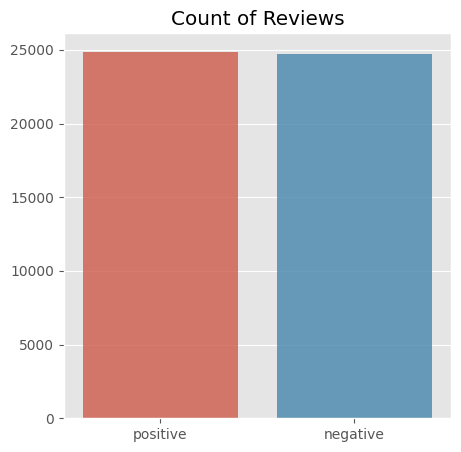

In [ ]:
# Plot a barplot to see a distribution of a target variable
sns.barplot(x=df.sentiment.value_counts().index, y=df.sentiment.value_counts().values, alpha=0.8)
plt.title('Count of Reviews');

In [ ]:
# Example of a positive review
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
# Example of a negative review
df['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

# Text preprocessing (cleaning, normalization, tokenization)

In [ ]:
# Replace NaN with a blank/empty string
df['review'] = df['review'].replace(np.nan, '', regex=True)

# Replace emoji with text
df['review'] = df['review'].apply(emoji.demojize)

# Remove !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
df['review'] = df['review'].apply(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

In [ ]:
# Remove HTML, XML, etc. markup and metadata
def remove_html(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'',text)

# Remove URL
def remove_url(text):
    url = re.compile(r'http(s*)?://\S+|www\.\S+')
    return url.sub(r'',text)

# Convert numbers into words
def convert_num(text):
    return re.sub(r'\d+', '', text)

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    # typos, slang and informal abbreviations
    phrase = re.sub(r"w/e", "whatever", phrase)
    phrase = re.sub(r"w/", "with", phrase)
    phrase = re.sub(r"ph0tos", "photos", phrase)
    phrase = re.sub(r"amirite", "am I right", phrase)
    phrase = re.sub(r"<3", "love", phrase)
    phrase = re.sub(r"trfc", "traffic", phrase)
    phrase = re.sub(r"lmao", "laughing my ass off", phrase)
    return phrase

In [ ]:
# print(stopwords.words('english'))

In [ ]:
# Remove from the list stop words that could prevent to correctly identify sentiment
# stopwords = set(stopwords.words('english')) - {"not", "nor"}

In [ ]:
# Clean, open contractions, normalize (lemmatize), tokenize
def token_lem(text):
    wnl = WordNetLemmatizer()
    min_length = 3

    text = text.strip()  # remove white spaces (horizontal tabs)
    text = text.lower()  # converting all letters to lower case
    text = remove_html(text)
    text = remove_url(text)
    text = convert_num(text)
    text = decontracted(text)

    words = [
        wnl.lemmatize(i,j[0])
        if j[0] in ['a','n','v']
        else wnl.lemmatize(i)
        for i,j in pos_tag(word_tokenize(text))]

    """Experiments showed that without removing stopwords metrics are better."""
    # words = [word for word in words
    #               if word not in stopwords]
    p = re.compile('[a-zA-Z]+');
    filtered_tokens = list(filter(lambda token:
                  p.match(token) and len(token) >= min_length,
         words))
    return filtered_tokens

# Train/Test Split #

In [ ]:
# Assign variables to predictor and predictand
X = df['review']
y = df['sentiment']

In [ ]:
# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Check shapes of train/test and target subsets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39665,), (9917,), (39665,), (9917,))

In [ ]:
# Encode a target variable
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Multinomial Naive Bayes (baseline)

In this project, there are different vectorization, with different parmeters, for each model.

In [ ]:
# Vectorize
vectorizer = TfidfVectorizer(tokenizer=token_lem,
                             ngram_range=(2,2))  # bigrams

X_train_mnb = vectorizer.fit_transform(X_train)
X_test_mnb = vectorizer.transform(X_test)

In [ ]:
# Create a model, then train it
mnb = MultinomialNB()
mnb_pred = classifier(mnb, X_train_mnb, y_train, X_test_mnb)

In [ ]:
accuracy_score(y_test, mnb_pred)

0.8888776847837048

Our data set is balanced but anyway let's see recall and precision.

In [ ]:
print(classification_report(y_test, mnb_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4939
           1       0.89      0.88      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



Precision is a bit better for positive reviews (target variable is encoded as negative review is 0, positive review is 1).

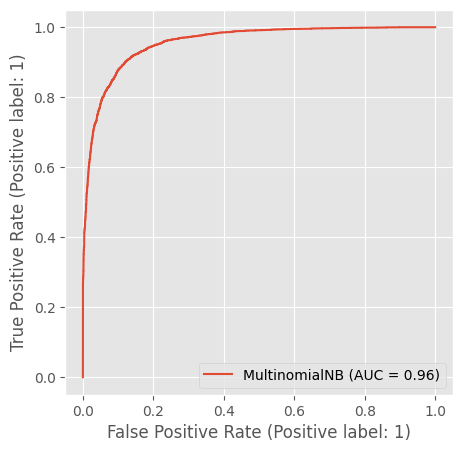

In [ ]:
RocCurveDisplay.from_estimator(mnb, X_test_mnb, y_test);

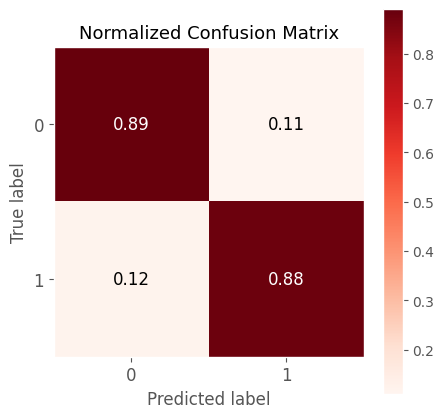

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test, mnb_pred, normalize=True,
    cmap='Reds', title_fontsize=13, text_fontsize=12
    )
plt.show()

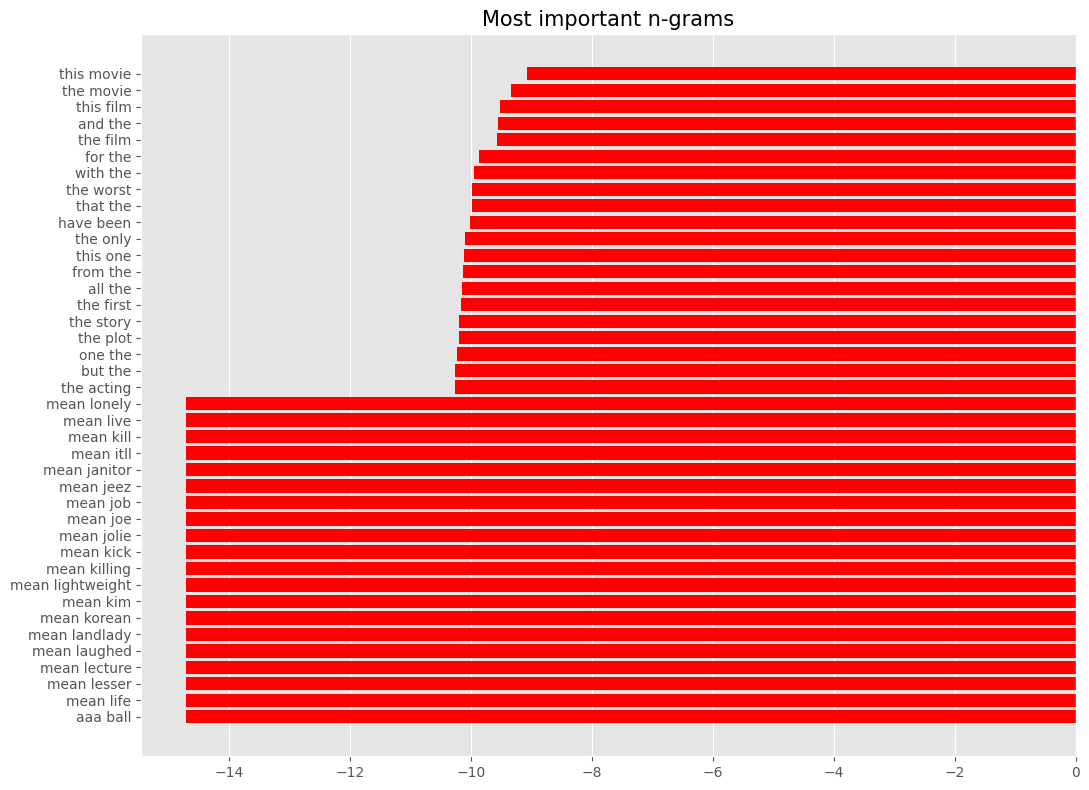

In [ ]:
plot_coeffs(mnb.feature_log_prob_[0], vectorizer.get_feature_names_out())

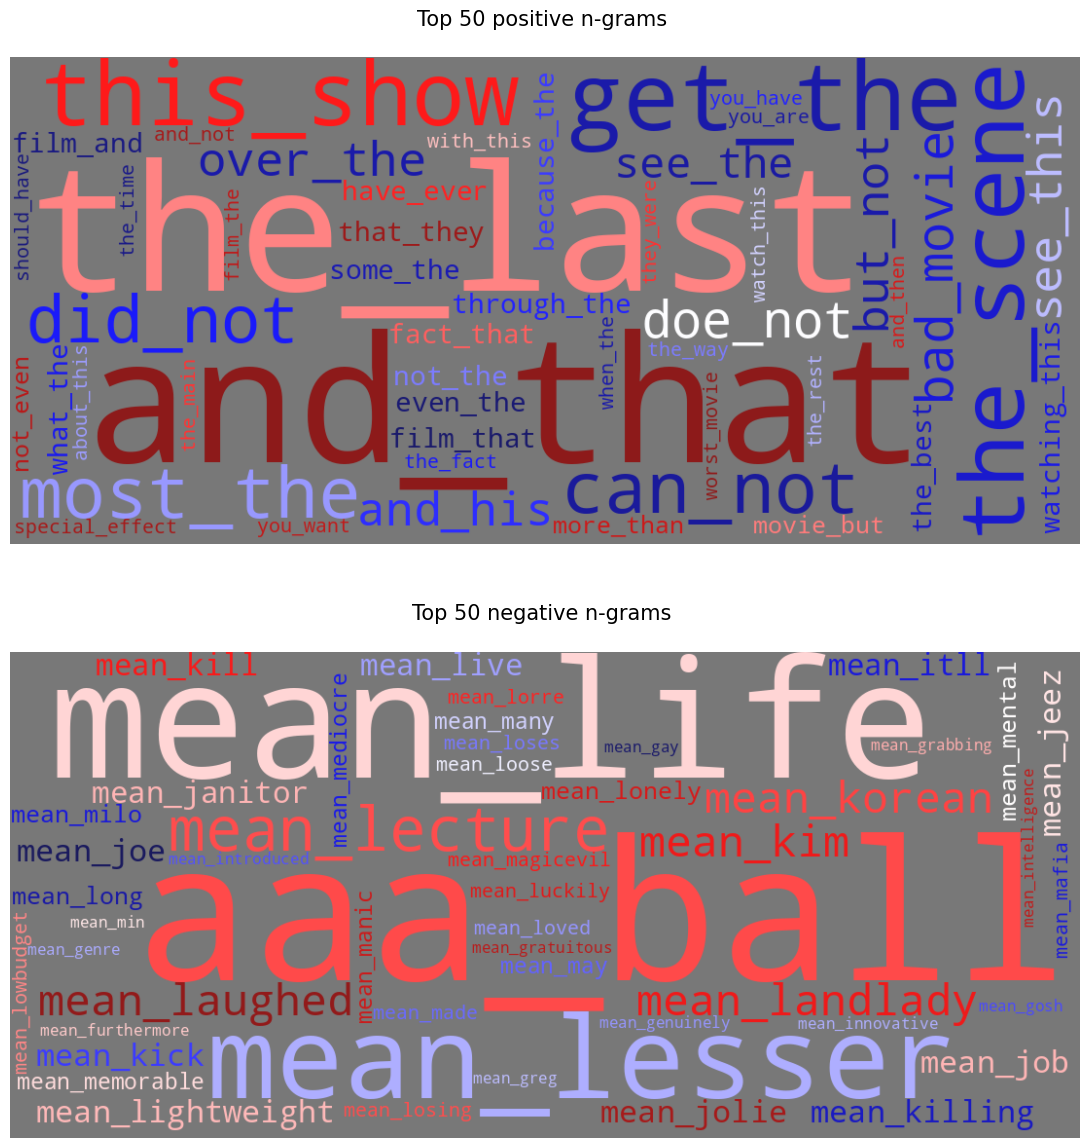

In [ ]:
plot_wordcloud(mnb.feature_log_prob_[0], vectorizer.get_feature_names_out())

# LinearSVC (baseline) #

In [ ]:
# Vectorize
vectorizer = TfidfVectorizer(tokenizer=token_lem,
                             ngram_range=(1,2))  # unigrams and bigrams

X_train_svc = vectorizer.fit_transform(X_train)
X_test_svc = vectorizer.transform(X_test)

In [ ]:
# Create a model, then train it
svc = LinearSVC(random_state=42)
svc_pred = classifier(svc, X_train_svc, y_train, X_test_svc)

In [ ]:
accuracy_score(y_test, svc_pred)

0.9074316829686397

In [ ]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      4939
           1       0.89      0.93      0.91      4978

    accuracy                           0.91      9917
   macro avg       0.91      0.91      0.91      9917
weighted avg       0.91      0.91      0.91      9917



Precision is better for negative reviews.

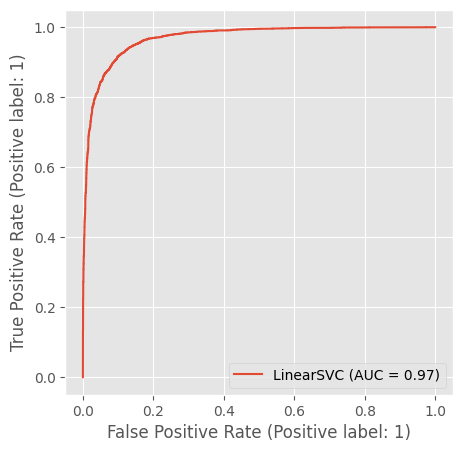

In [ ]:
RocCurveDisplay.from_estimator(svc, X_test_svc, y_test);

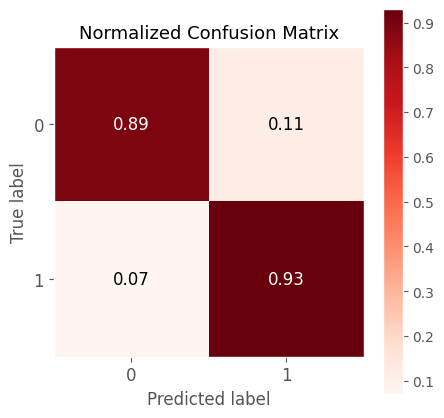

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test, svc_pred, normalize=True,
    cmap='Reds', title_fontsize=13, text_fontsize=12
    )
plt.show()

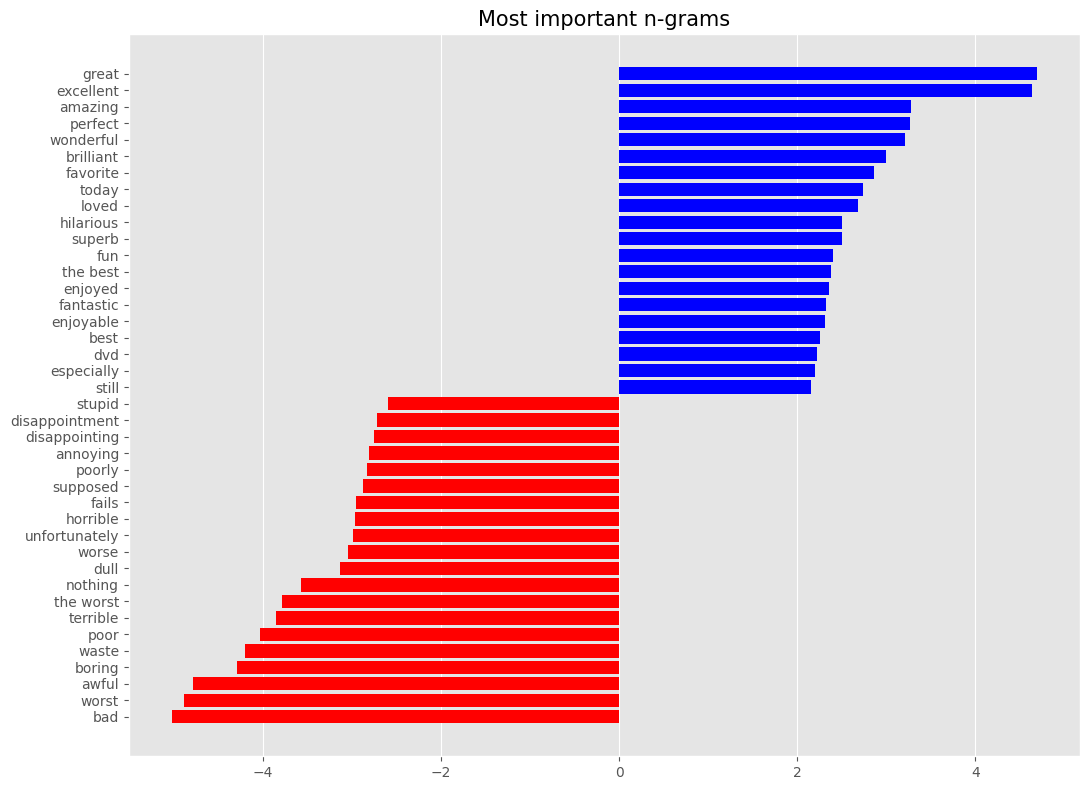

In [ ]:
plot_coeffs(svc.coef_, vectorizer.get_feature_names_out())

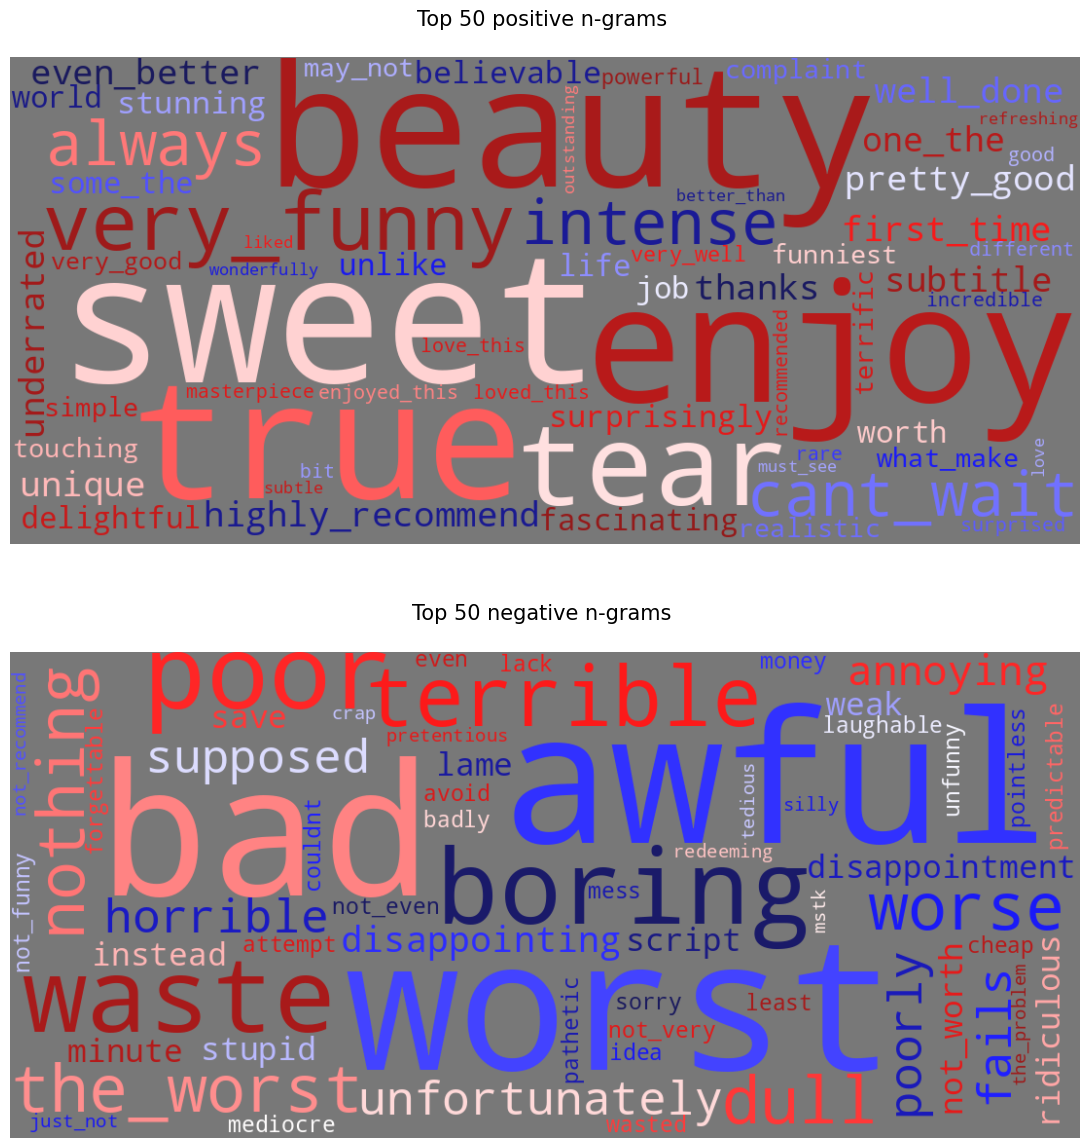

In [ ]:
plot_wordcloud(svc.coef_, vectorizer.get_feature_names_out())

# SGDClassifier (baseline) #

In [ ]:
# Vectorize
vectorizer = TfidfVectorizer(tokenizer=token_lem,
                             ngram_range=(1,2),  # unigrams and bigrams
                             max_features=20000)  # build a vocab that only consider the top max_features ordered by TF across the corpus

X_train_sgd = vectorizer.fit_transform(X_train)
X_test_sgd = vectorizer.transform(X_test)

In [ ]:
# Create a model, then train it
sgd = SGDClassifier(loss='log', random_state=42)
y_pred = classifier(sgd, X_train_sgd, y_train, X_test_sgd)

In [ ]:
accuracy_score(y_test, y_pred)

0.8812140768377533

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4939
           1       0.87      0.90      0.88      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



Precision is better for negative reviews.

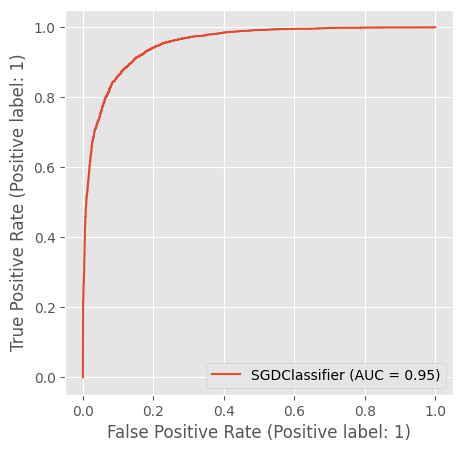

In [ ]:
RocCurveDisplay.from_estimator(sgd, X_test_sgd, y_test);

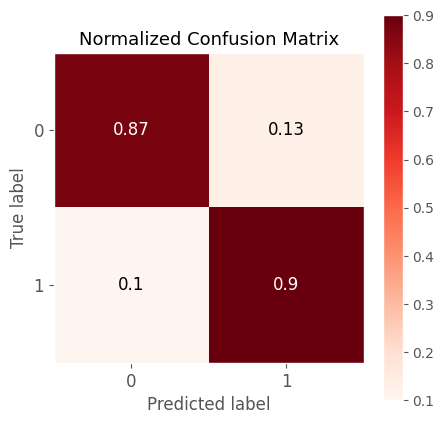

In [ ]:
skplt.metrics.plot_confusion_matrix(
    y_test, y_pred, normalize=True,
    cmap='Reds', title_fontsize=13, text_fontsize=12)
plt.show()

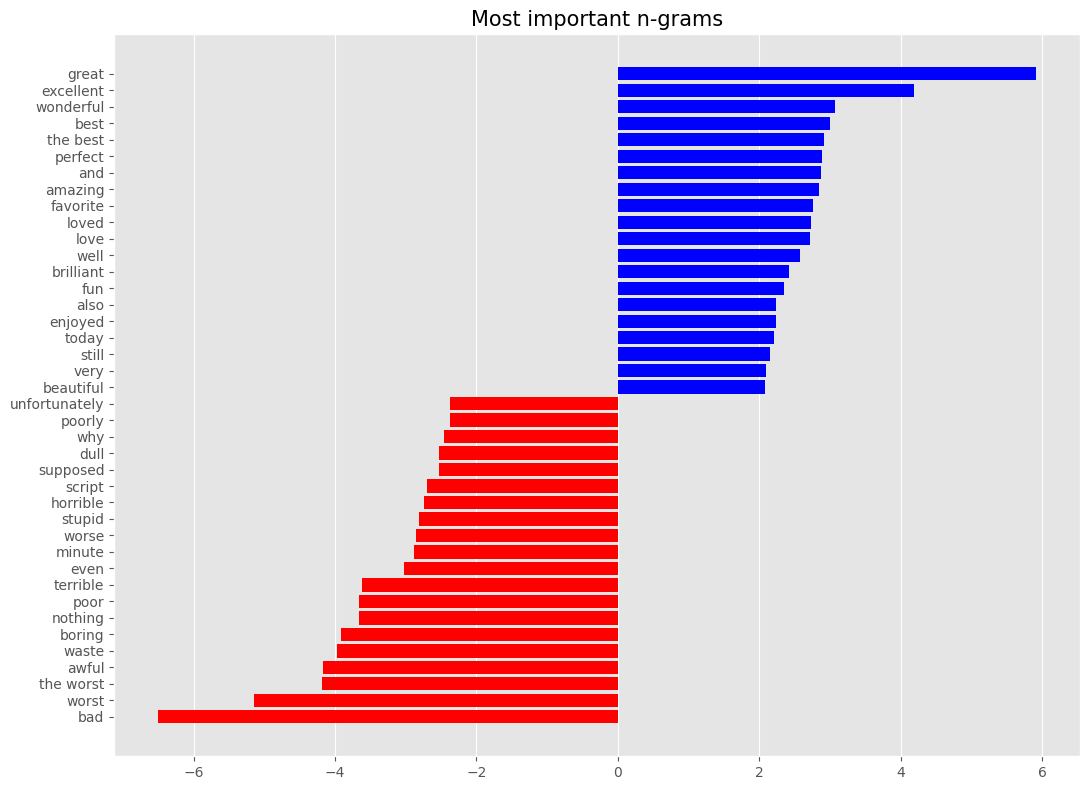

In [ ]:
plot_coeffs(sgd.coef_, vectorizer.get_feature_names_out())

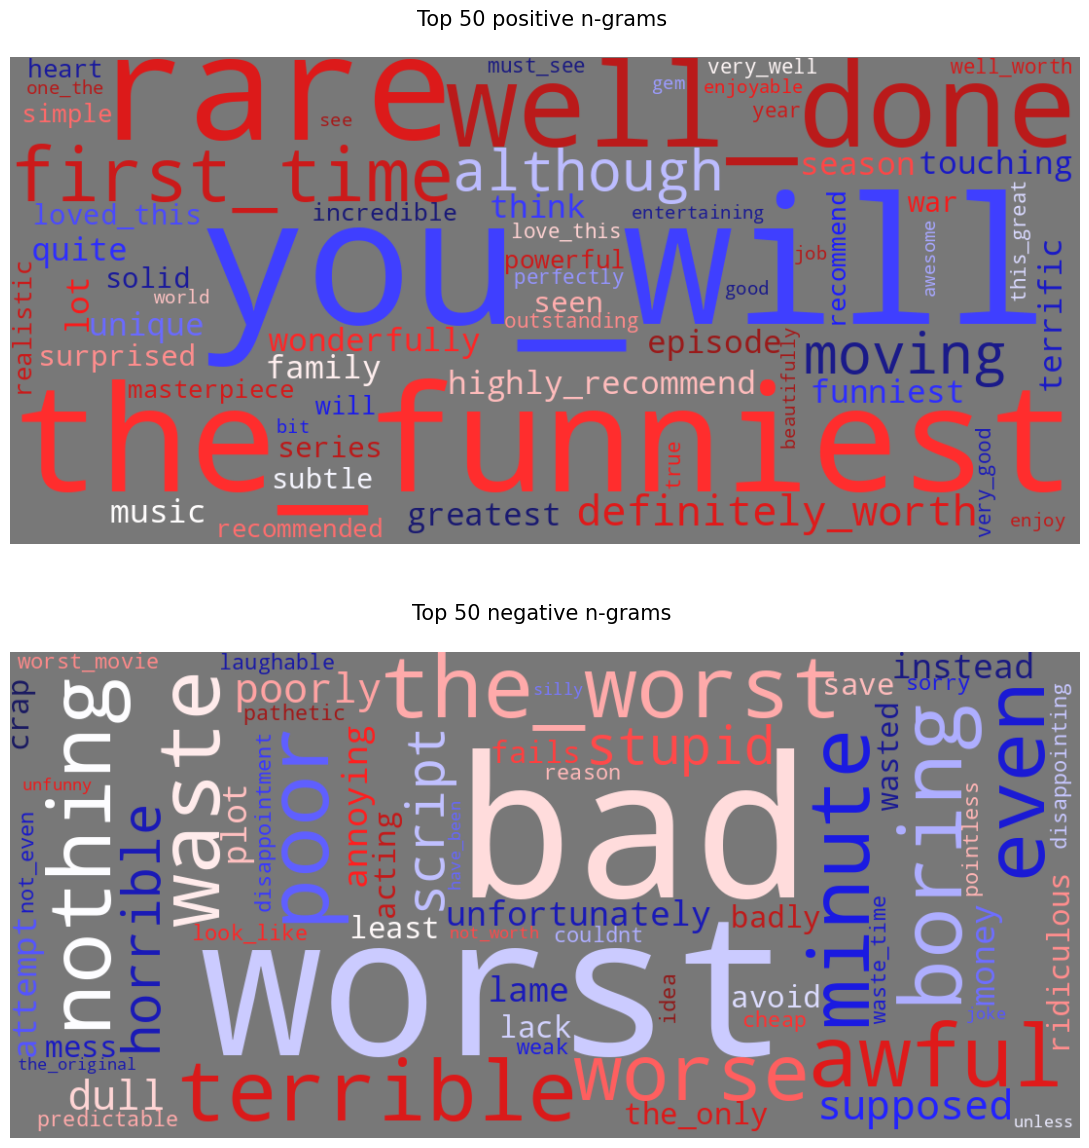

In [ ]:
plot_wordcloud(sgd.coef_, vectorizer.get_feature_names_out())

# Hyperparameters tuning for all classifiers

In [ ]:
# Create a dictionary with hyperparameters for each model
params = {
    'MultinomialNB': {
        'alpha': [1e-10, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0, 1e0, 1e+1, 1e+2, 1e+3]
        },
    'LinearSVC': {
        'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
        'loss': ['squared_hinge', 'hinge']
        },
    'SGDClassifier': {
        'learning_rate': ['optimal', 'adaptive'],
        'loss': ['hinge', 'log'],
        'penalty': ['l2', 'elasticnet', None]
        }
}

NB: For LinearSVC the ‘l2’ penalty is default, and it is the standard used in SVC. The ‘l1’ leads to sparse coef_ vectors.

In [ ]:
# Search for optimal hyperparameters
%%time
mnb, mnb_best_params = gridsearch(
    MultinomialNB(), params['MultinomialNB'],
    X_train_mnb, y_train
    )
svc, svc_best_params = gridsearch(
    LinearSVC(random_state=42), params['LinearSVC'],
    X_train_svc, y_train
    )
sgd, sgd_best_params = gridsearch(
    SGDClassifier(loss='log', random_state=42), params['SGDClassifier'],
    X_train_sgd, y_train
    )

mnb_pred = mnb.predict(X_test_mnb)
svc_pred = svc.predict(X_test_svc)
sgd_pred = sgd.predict(X_test_sgd)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 7.98 s, sys: 831 ms, total: 8.82 s
Wall time: 4min 42s


MultinomialNB:

Optimal hyperparameters: {'alpha': 0.1}
Accuracy: 0.8920036301300797

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4939
           1       0.89      0.89      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



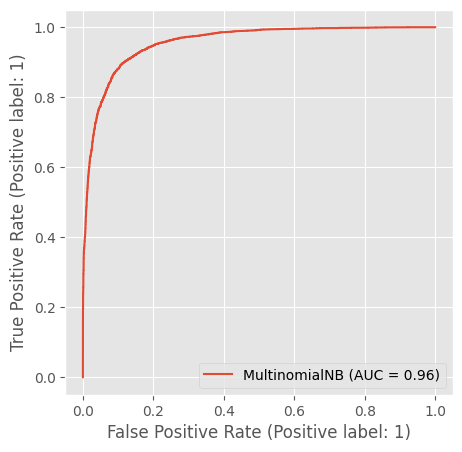

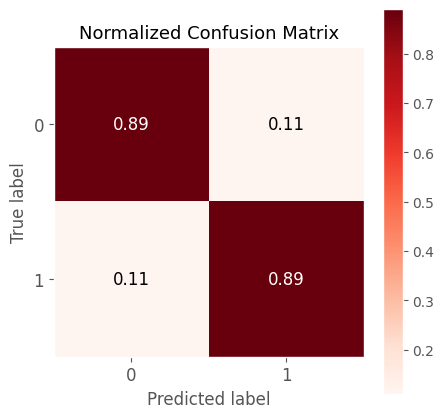


LinearSVC:

Optimal hyperparameters: {'C': 1.0, 'loss': 'squared_hinge'}
Accuracy: 0.9074316829686397

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      4939
           1       0.89      0.93      0.91      4978

    accuracy                           0.91      9917
   macro avg       0.91      0.91      0.91      9917
weighted avg       0.91      0.91      0.91      9917



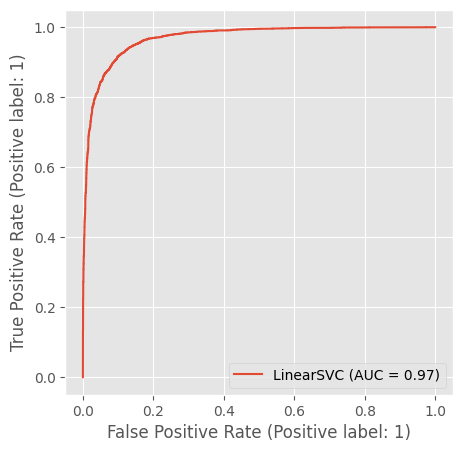

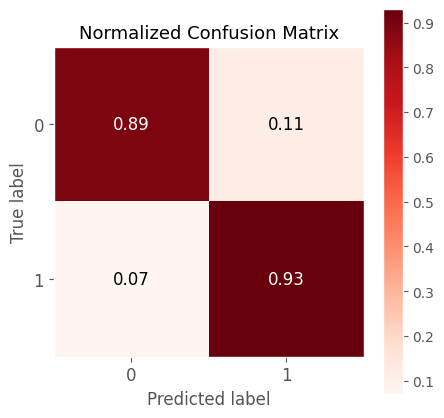


SGDClassifier:

Optimal hyperparameters: {'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'}
Accuracy: 0.8936170212765957

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      4939
           1       0.88      0.92      0.90      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



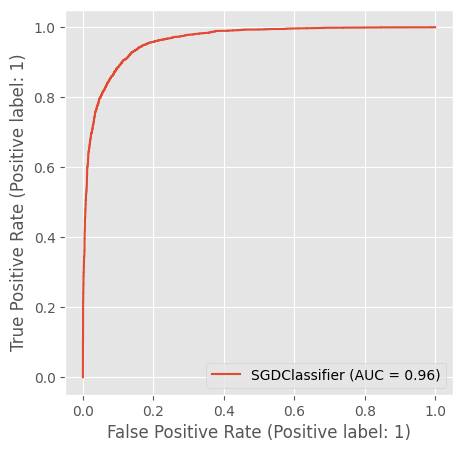

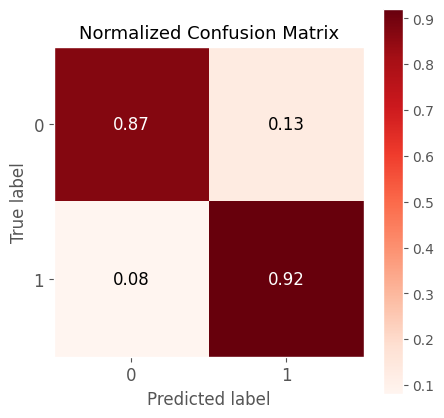

In [ ]:
# Print best parameters and metrics for each classifier
print('MultinomialNB:\n')
print('-'*30)
print(f'Optimal hyperparameters: {mnb_best_params}')
print(f'Accuracy: {accuracy_score(y_test, mnb_pred)}\n')
print(classification_report(y_test, mnb_pred))
RocCurveDisplay.from_estimator(mnb, X_test_mnb, y_test)
skplt.metrics.plot_confusion_matrix(
    y_test, mnb_pred, normalize=True,
    cmap='Reds', title_fontsize=13, text_fontsize=12
    )
plt.show()


print('\nLinearSVC:\n')
print('-'*30)
print(f'Optimal hyperparameters: {svc_best_params}')
print(f'Accuracy: {accuracy_score(y_test, svc_pred)}\n')
print(classification_report(y_test, svc_pred))
RocCurveDisplay.from_estimator(svc, X_test_svc, y_test)
skplt.metrics.plot_confusion_matrix(
    y_test, svc_pred, normalize=True,
    cmap='Reds', title_fontsize=13, text_fontsize=12
    )
plt.show()


print('\nSGDClassifier:\n')
print('-'*30)
print(f'Optimal hyperparameters: {sgd_best_params}')
print(f'Accuracy: {accuracy_score(y_test, sgd_pred)}\n')
print(classification_report(y_test, sgd_pred))
RocCurveDisplay.from_estimator(sgd, X_test_sgd, y_test)
skplt.metrics.plot_confusion_matrix(
    y_test, sgd_pred, normalize=True,
    cmap='Reds', title_fontsize=13, text_fontsize=12
    )
plt.show()

# Conclusions

* **AUC score** (baseline/after hyperparameters tuning):

LinearSVC – 0.97/0.97\
Multinomial Naive Bayes – 0.96/0.96\
SGDClassifier – 0.95/0.96
* **Accuracy** (baseline/after hyperparameters tuning):

LinearSVC – 0.9074/0.9074\
Multinomial Naive Bayes – 0.888/0.892\
SGDClassifier – 0.881/0.8936
* Hyperparameters tuning helped to improve SGDClassifier's performance; it didn't change Naive Bayes model metrics significantly and didn't change LinearSVC model metrics at all. The reason of the latter that is all hyperparameters that were found by GridSearchCV for LinearSVC are default ones.
* Training models **without removing stop words** gave **better result** for all models.
* For LinearSVC better result was given by model with TF-IDF vectorization that used unigrams and bigrams and all features,\
Multinomial Naive Bayes – bigrams and all features,\
SGDClassifier – unigrams and bigrams, top 20,000 features.
